Rabbit Gastrulation Atlas

Based on Batch Correction analysis of mouse embryo atlas (Pijuan-Sala et al. 2019)

Mai-Linh Ton
April 13, 2020

In [1]:
library(Matrix)
library(scran)
library(Rtsne)
#set it up for scran to be properly parallelised
library(BiocParallel)
ncores = 16
mcparam = SnowParam(workers = ncores)
register(mcparam)
library(irlba)
library(batchelor)
library(cowplot)

source("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/core_functions.R")
load_data(remove_doublets = TRUE, remove_stripped = TRUE)

nPC = 50

summary(meta)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, r

     cell             barcode              sample         stage          
 Length:146133      Length:146133      Min.   : 1.00   Length:146133     
 Class :character   Class :character   1st Qu.:10.00   Class :character  
 Mode  :character   Mode  :character   Median :17.00   Mode  :character  
                                       Mean   :15.84                     
                                       3rd Qu.:22.00                     
                                       Max.   :26.00                     
     batch    doub.density        doublet         stripped      
 Min.   :1   Min.   :      0.0   Mode :logical   Mode :logical  
 1st Qu.:1   1st Qu.:     12.4   FALSE:146133    FALSE:146133   
 Median :1   Median :     41.2                                  
 Mean   :1   Mean   :    956.8                                  
 3rd Qu.:1   3rd Qu.:    140.2                                  
 Max.   :1   Max.   :1225923.0                                  

In [4]:
getHVGs <- function(sce, min.mean = 1e-3, sparse_matrix = FALSE){
 if(sparse_matrix == FALSE){
   trend  <- scran::trendVar(sce, use.spikes = FALSE, loess.args = list(span = 0.05))
 }else{
   trend  <- scran::trendVar(sce, loess.args = list(span = 0.05))
 }
 decomp <- scran::decomposeVar(sce, fit = trend)
 decomp <- decomp[decomp$mean > min.mean,]
 rabbit_ensembl = biomaRt::useMart("ensembl", dataset="ocuniculus_gene_ensembl")
 gene_map <- biomaRt::getBM(attributes=c("ensembl_gene_id",  "chromosome_name"), values = genes, mart = rabbit_ensembl)
 decomp$FDR <- p.adjust(decomp$p.value, method = "fdr")
 out        <- rownames(decomp)[decomp$p.value < 0.05]
 message("Number of highly variable genes: ",length(out))
 return(out)
}

hvgs = getHVGs(sce)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5405



In [5]:
#get order: oldest to youngest; most cells to least cells
order_df = meta[!duplicated(meta$sample), c("stage", "sample")]
order_df$ncells = sapply(order_df$sample, function(x) sum(meta$sample == x))
order_df$stage = factor(order_df$stage, 
                        levels = rev(c("GD9", 
                                   "GD8", 
                                   "GD7")))
order_df = order_df[order(order_df$stage, order_df$ncells, decreasing = TRUE),]
order_df$stage = as.character(order_df$stage)


In [6]:
all_correct = doBatchCorrect(counts = logcounts(sce)[rownames(sce) %in% hvgs,], 
                             timepoints = meta$stage, 
                             samples = meta$sample, 
                             timepoint_order = order_df$stage, 
                             sample_order = order_df$sample, 
                             npc = 50,
                             BPPARAM = mcparam)
                        
# save(all_correct, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/6.batch_correct/all_correction.RData")
#load("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT04_rabbit/batch_correct/all_correction.RData")

Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”


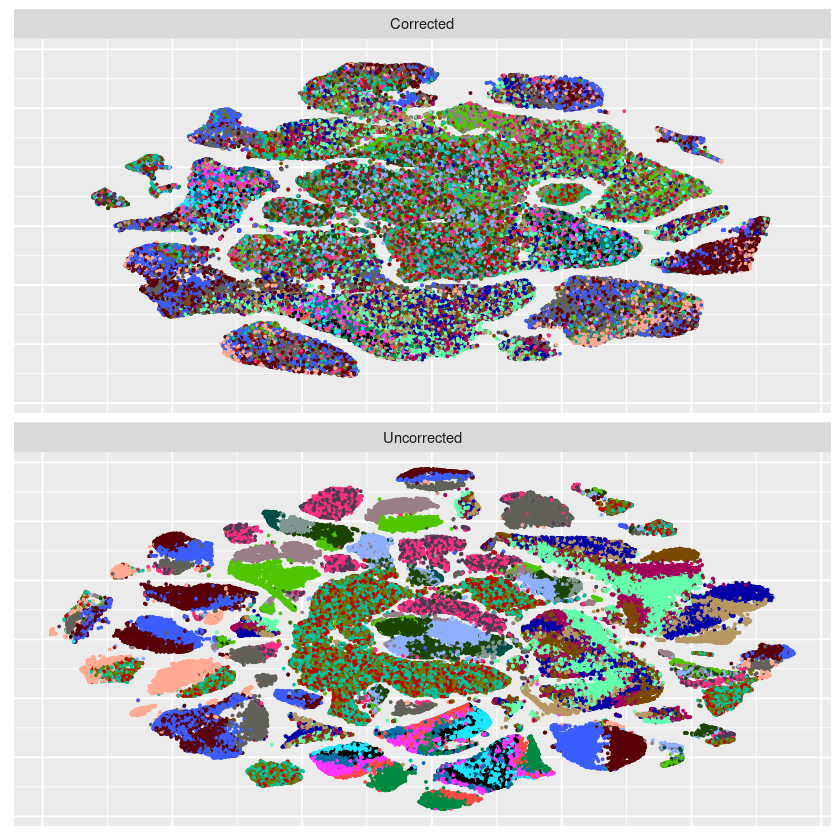

In [7]:
base_pca = prcomp_irlba(t(logcounts(sce)[rownames(sce) %in% hvgs,]), n = nPC)$x
base_tsne = Rtsne(base_pca, pca = FALSE)$Y
corrected_tsne = Rtsne(all_correct, pca = FALSE)$Y

base_tsne = as.data.frame(base_tsne)
base_tsne$sample = meta$sample
base_tsne$state = "Uncorrected"

corrected_tsne = as.data.frame(corrected_tsne)
corrected_tsne$sample = meta$sample
corrected_tsne$state = "Corrected"

bc_tsne = rbind(base_tsne, corrected_tsne)

reorder = sample(nrow(bc_tsne), nrow(bc_tsne))

ggplot(bc_tsne[reorder,], aes(x = V1, y = V2, col = factor(sample))) +
  geom_point(size = 0.4) +
  scale_colour_Publication() +
  theme(legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  facet_wrap(~state, nrow = 2)

In [8]:
stage_corrections = lapply(unique(meta$stage), function(x){
  sub_sce = normalize(sce[,meta$stage == x])
  sub_meta = meta[meta$stage == x,]
  hvgs = getHVGs(sub_sce)
  
  correct = doBatchCorrect(counts = logcounts(sub_sce)[rownames(sub_sce) %in% hvgs,], 
                           timepoints = sub_meta$stage, 
                           samples = sub_meta$sample, 
                           timepoint_order = order_df$stage, 
                           sample_order = order_df$sample, 
                           npc = 50,
                           BPPARAM = mcparam)
  return(correct)
  
})
names(stage_corrections) = unique(meta$stage)

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5303

Warning message:
“'pc.input=TRUE' and 'use.dimred=TRUE' are deprecated.
Use 'reducedMNN' instead.”
Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is dep

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5303

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”
Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”
Warning message:
“'testVar' is deprecated.
See help("Deprecated")”
Cache found

Number of highly variable genes: 5581

Warning messag

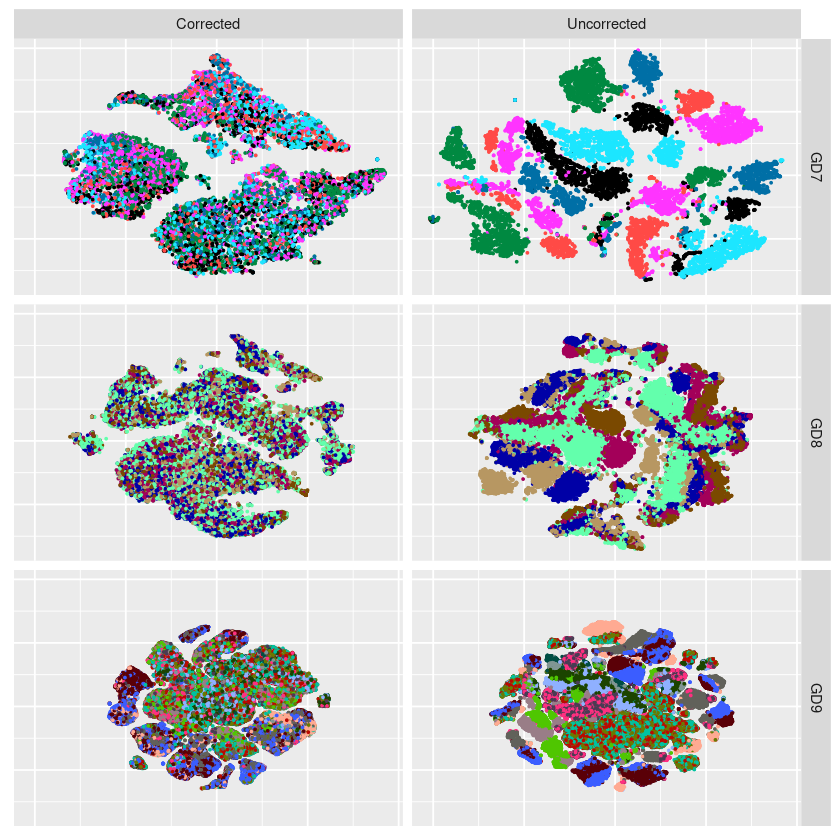

In [9]:
tsnes = lapply(stage_corrections, Rtsne, pca = FALSE)
tsnes = lapply(tsnes, function(x) as.data.frame(x$Y))
for(i in 1:length(tsnes)){
  tsnes[[i]]$stage = unique(meta$stage)[i]
  tsnes[[i]]$sample = meta$sample[meta$stage == unique(meta$stage)[i]]
  tsnes[[i]]$state = "Corrected"
}

base_pcas = lapply(unique(meta$stage), function(x){
  sub_sce = normalize(sce[,meta$stage == x])
  sub_meta = meta[meta$stage == x,]
  hvgs = getHVGs(sub_sce)
  
  pca = prcomp_irlba(t(logcounts(sub_sce)[rownames(sub_sce) %in% hvgs,]), n = nPC)
  return(pca$x)
})
base_tsnes = lapply(base_pcas, Rtsne, pca = FALSE)
base_tsnes = lapply(base_tsnes, function(x) as.data.frame(x$Y))
for(i in 1:length(base_tsnes)){
  base_tsnes[[i]]$stage = unique(meta$stage)[i]
  base_tsnes[[i]]$sample = meta$sample[meta$stage == unique(meta$stage)[i]]
  base_tsnes[[i]]$state = "Uncorrected"
}

big_df = rbind(
  do.call(rbind, base_tsnes),
  do.call(rbind, tsnes)
)

reorder = sample(nrow(big_df), nrow(big_df))

ggplot(big_df[reorder,], aes(x = V1, y = V2, col = factor(sample))) +
  geom_point(size = 0.4) +
  scale_colour_Publication() +
  theme(legend.position = "none",
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  facet_grid(stage~state)

In [11]:
corrections = list("all" = all_correct, "stage" = stage_corrections)
saveRDS(corrections, file = "/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/corrected_pcas.rds")
#=Saving Workspace in order to more easily go back and adjust it in the future=#
save.image("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/bc_workspace.RData")

In [2]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Scientific Linux 7.8 (Nitrogen)

Matrix products: default
BLAS:   /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/r-3.6.1-zrytncqvsnw5h4dl6t6njefj7otl4bg4/rlib/R/lib/libRblas.so
LAPACK: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/r-3.6.1-zrytncqvsnw5h4dl6t6njefj7otl4bg4/rlib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scater_1.14.6               ggplot2_3.3.

In [8]:
## Final cells retained for analysis and compiling variables for saving

split_bc = strsplit(as.character(barcodes), "-", fixed = T)
bcs = sapply(split_bc, function(x) x[1])
samples = sapply(split_bc, function(x) x[2])

meta = data.frame(cell = paste0("cell_", 1:ncol(counts)),
                  barcode = bcs,
                  sample = as.numeric(samples),
                  stage = stage_match$stage[match(samples, stage_match$sample)],
                  batch = stage_match$batch[match(samples, stage_match$sample)])

tab = as.matrix(table(meta$sample, meta$stage))

new_rownames = c("Total", rownames(tab))
tab = rbind(sapply(colnames(tab), function(x) sum(meta$stage == x)),
            tab)
rownames(tab) = new_rownames

pt = kable(tab, caption = "Number of cells retained for analysis")
pt

ERROR: Error in data.frame(cell = paste0("cell_", 1:ncol(counts)), barcode = bcs, : object 'stage_match' not found
